Testing surface oil beaching using [Parcels](https://oceanparcels.org)

In [1]:
import sys
import os
import math
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
from pprint import pprint
from parcels import VectorField, Variable #AdvectionRK4
from parcels import FieldSet, plotTrajectoriesFile, Variable, ScipyParticle, Field, ParcelsRandom
import numpy as np
from datetime import timedelta
sys.path.append('/ocean/rlovindeer/Atlantis/ssam_oceanparcels/Parcels_Utils/particle_tracking/parcels/')
from util.seed_particles import get_particles, get_release_times
# from util.parse_wildcards import parse_wildcards

INFO: Compiled ParcelsRandom ==> /tmp/parcels-2926/libparcels_random_3efd8367-1c5f-49c1-b0ac-9c82aa4a4bf2.so


In [2]:
# Spill release times
release_start_time = '2018-06-23'  ## winter start on December, Summer Jul - Aug  ## ask Susan about when to do simulation
release_end_time = '2018-06-24'
release_YYYY = '2018-06'

Select the location of interest, which is specified by a shapefile.

In [3]:
file_id = int(input( ))
scenario = {1 : "5b_Turn_Point_Diluted_bitumen",
            2 : "6a_VancouverHarbour_BunkerC",
            3 : "7a_JohnsonStrait_BunkerC",
            4 : "4a_ActivePass_Diesel",
            5 : "SandHeads"}
print("\nScenario running  :", scenario[file_id], sep = " ")


Scenario running  : SandHeads


In [4]:
#Kernels

def AdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
    Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        (u1, v1) = fieldset.UV[particle]
        lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
        (u2, v2) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat1, lon1, particle]
        lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
        (u3, v3) = fieldset.UV[time + .5 * particle.dt, particle.depth, lat2, lon2, particle]
        lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
        (u4, v4) = fieldset.UV[time + particle.dt, particle.depth, lat3, lon3, particle]
        particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
        particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    
def WindAdvectionRK4(particle, fieldset, time):
    """Advection of particles using fourth-order Runge-Kutta integration.
     Function needs to be converted to Kernel object before execution"""
    if particle.beached == 0:
        wp = fieldset.wind_percentage ## this need to be add to the fieldset
        
        if wp > 0:

            (u1, v1) = fieldset.UVwind[time, particle.depth, particle.lat, particle.lon]
            u1 = u1 * wp
            v1 = v1 * wp
            lon1, lat1 = (particle.lon + u1*.5*particle.dt, particle.lat + v1*.5*particle.dt)
            
            (u2, v2) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat1, lon1]
            u2 = u2 * wp
            v2 = v2 * wp
            lon2, lat2 = (particle.lon + u2*.5*particle.dt, particle.lat + v2*.5*particle.dt)
            
            (u3, v3) = fieldset.UVwind[time + .5 * particle.dt, particle.depth, lat2, lon2]
            u3 = u3 * wp
            v3 = v3 * wp
            lon3, lat3 = (particle.lon + u3*particle.dt, particle.lat + v3*particle.dt)
            
            (u4, v4) = fieldset.UVwind[time + particle.dt, particle.depth, lat3, lon3]
            u4 = u4 * wp
            v4 = v4 * wp            
            
            u_wind  = (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            v_wind  = (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
            particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
            
            particle.beached = 2

def beaching(particle, fieldset, time):
    
    if particle.beached == 2:
        
        # Parameters
        deg2m = 111000     # [m/deg]
        D = 50      # maximum beaching distance [m]
        
        # Grounding probability over radius D
        offset_lon = random.uniform(-1., 1.) * D / deg2m
        offset_lat = random.uniform(-1., 1.) * D / deg2m

        # Evaluate if chosen point is over land
        (u, v) = fieldset.UV[time, particle.depth, particle.lat + offset_lat, particle.lon + offset_lon]
        if u == 0 and v == 0: 
            particle.beached = 1
        else:
            particle.beached = 0

def DeleteParticle(particle, fieldset, time):
    particle.delete()

def DecayParticle(particle, fieldset, time):
    dt = particle.dt
    field_decay_value = fieldset.decay
    decay = math.exp(0 * dt/field_decay_value) # -0.099 for diesel, 0 for other oils
    particle.decay_value = particle.decay_value * decay

In [5]:
# Data Paths
currents = Path('/ocean/rlovindeer/Atlantis/Physics/Raw_Transport_Data/')
winds = Path('/ocean/rlovindeer/Atlantis/Physics/Wind/')
sea_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc')
air_grid = Path('/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc')

In [6]:
# Salish Sea NEMO Model Grid, Geo-location and Bathymetry, v17-02

# Currents
# u_data_path = currents + '2018-01*URaw_variables.nc'
# v_data_path = currents + '2018-01*VRaw_variables.nc'
# u_current = parse_wildcards(u_data_path, 'u')
# v_current = parse_wildcards(v_data_path, 'v')

u_current = sorted([p for p in currents.glob(str(release_YYYY) + '*URaw_variables.nc')])
v_current = sorted([p for p in currents.glob(str(release_YYYY) + '*VRaw_variables.nc')])

filenames = {
    'U': {'lon': sea_grid,'lat': sea_grid,'data': u_current},
    'V': {'lon': sea_grid,'lat': sea_grid,'data': v_current}
            }

variables = {'U': 'uVelocity','V': 'vVelocity'}
dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}
print('creating from_nemo')
fieldset = FieldSet.from_nemo(filenames, variables, dimensions, allow_time_extrapolation=True)
print('creating from_nemo done')

fieldset.add_constant('decay', 1.0 * 3600.0)
print('add_constant decay')

creating from_nemo
creating from_nemo done
add_constant decay


In [7]:
# HRDPS, Salish Sea, Atmospheric Forcing Grid, Geo-location, v1"

wind_paths = sorted([p for p in winds.glob(str(release_YYYY) + '*Wind_variables.nc')])
wind_filenames = {'lon': os.fspath(air_grid),'lat': os.fspath(air_grid),'data': wind_paths}
wind_dimensions = {'lon': 'longitude', 'lat': 'latitude', 'time': 'time'}

pprint(wind_filenames)

{'data': [PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2018-06-01_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2018-06-07_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2018-06-13_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2018-06-19_Wind_variables.nc'),
          PosixPath('/ocean/rlovindeer/Atlantis/Physics/Wind/2018-06-25_Wind_variables.nc')],
 'lat': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc',
 'lon': '/ocean/rlovindeer/Atlantis/Physics/Grids/ubcSSaAtmosphereGridV1_0f03_6268_df4b.nc'}


In [8]:
Uwind_field = Field.from_netcdf(wind_filenames, ('U_wind', 'u_wind'),
                                     wind_dimensions,
                                     fieldtype='U',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)
Vwind_field = Field.from_netcdf(wind_filenames, ('V_wind', 'v_wind'),
                                     wind_dimensions,
                                     fieldtype='V',
                                     allow_time_extrapolation=True,
                                     transpose=False,
                                     deferred_load=False)

print('wind data loaded')

wind data loaded


In [9]:
# change longitude for the wind field
Uwind_field.grid.lon = Uwind_field.grid.lon - 360
Vwind_field.grid.lon = Vwind_field.grid.lon - 360

[x_min, x_max, y_min, y_max] = Uwind_field.grid.lonlat_minmax

Uwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]
Vwind_field.grid.lonlat_minmax = [x_min - 360, x_max - 360, y_min, y_max]

## adding the wind field to the fieldset object
fieldset.add_field(Uwind_field)
fieldset.add_field(Vwind_field)
wind_field = VectorField('UVwind', Uwind_field,  Vwind_field)
fieldset.add_vector_field(wind_field)

In [10]:
# wind_percentage
# We need to do a sensitivity analysis of the percetage of wind to be used here
wind_percentage = 1
fieldset.add_constant('wind_percentage', wind_percentage/100.0)

In [11]:
class MyParticle(ScipyParticle):
    initial_time = -100
    decay_value = Variable('decay_value', dtype=np.float32, initial=1.0)
    beached = Variable('beached', dtype=np.int32, initial=0.)
    age = Variable('age', dtype=np.int32, initial=0.)

# Particle Features
num_particles_per_day = 100
feature_release_index = 0
input_shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/" + scenario[file_id] + ".shp"
release_depth = -0.1
release_start_time = np.datetime64(release_start_time)
release_end_time = np.datetime64(release_end_time)
time_origin = fieldset.U.grid.time_origin.time_origin

print('setting up particles')

[release_times, p, num_particles] = get_release_times(time_origin, num_particles_per_day, release_start_time, release_end_time)
pset = get_particles(fieldset, num_particles, input_shapefile_name, MyParticle, feature_release_index, release_times, release_depth)

#print(pset)

# Building the kernels
decay_kernel = pset.Kernel(DecayParticle)
beaching_kernel = pset.Kernel(beaching)
ForcingWind_kernel = pset.Kernel(WindAdvectionRK4)
Advection_kernel = pset.Kernel(AdvectionRK4)

# Adding to the main kernel
my_kernel = Advection_kernel + decay_kernel + ForcingWind_kernel + beaching_kernel

output_file_name = scenario[file_id] + str(release_start_time) +  '_OP_D50.nc'
print(output_file_name)

setting up particles
1812600.0
100
100
Using shapefile /ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/Shape_Scenarios/SandHeads.shp
Number of sites :  1
Up to 0 of 1
80
100
Sucessfully seeded particles

num_attempts = 2
[-123.30000432049512, -123.29995172398498, -123.29998726528677, -123.30000556299005, -123.30004388699821, -123.2999736303387, -123.30003948253572, -123.29989590048521, -123.30005659964887, -123.29992752871306, -123.30001061737016, -123.29999824096845, -123.29988520779656, -123.30015027302439, -123.29991460061083, -123.29993181806454, -123.29990277975774, -123.29992517874757, -123.30003192949442, -123.29993106806816, -123.3001404270953, -123.2999755186161, -123.29987917846462, -123.30001284501579, -123.30004672991672, -123.30009418312827, -123.29993305826453, -123.30003361416416, -123.29999811787104, -123.30017187723496, -123.29998256375345, -123.29998431504593, -123.29998278551916, -123.2998794695699, -123.29996227297002, -123.30006416579926, -123.30003965806964

In [12]:
try:
    os.system('rm ' + output_file_name)
except:
    pass

print('executing particle kernel')

executing particle kernel


rm: cannot remove 'SandHeads2018-06-23_OP_D50.nc': No such file or directory


INFO: Temporary output files are stored in out-ZROQGYMT.
INFO: You can use "parcels_convert_npydir_to_netcdf out-ZROQGYMT" to convert these to a NetCDF file during the run.
N/A% (0 of 604800.0) |                   | Elapsed Time: 0:00:00 ETA:  --:--:--
  5% (32400.0 of 604800.0) |             | Elapsed Time: 0:00:02 ETA:   0:00:47
  5% (36000.0 of 604800.0) |             | Elapsed Time: 0:00:05 ETA:   0:06:57
  6% (39600.0 of 604800.0) |             | Elapsed Time: 0:00:08 ETA:   0:07:32
  7% (43200.0 of 604800.0) |             | Elapsed Time: 0:00:11 ETA:   0:07:25
  7% (45000.0 of 604800.0) |             | Elapsed Time: 0:00:13 ETA:   0:11:20
  7% (46800.0 of 604800.0) |#            | Elapsed Time: 0:00:14 ETA:   0:10:05
  8% (50400.0 of 604800.0) |#            | Elapsed Time: 0:00:19 ETA:   0:10:51
  8% (54000.0 of 604800.0) |#            | Elapsed Time: 0:00:23 ETA:   0:10:56
  9% (57600.0 of 604800.0) |#            | Elapsed Time: 0:00:27 ETA:   0:11:02
 10% (61200.0 of 604800.0) 

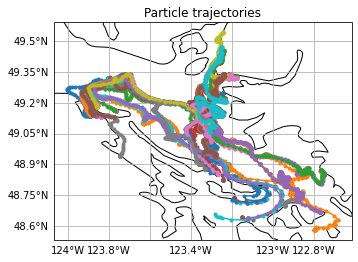

particle trajectories completed


In [13]:
## Output properties
output_file = pset.ParticleFile(name= output_file_name, outputdt = timedelta(minutes = 60))
pset.execute(my_kernel,                 # the kernel (which defines how particles move)
             runtime=timedelta(hours = 24*7),   # the total length of the run
             dt = timedelta(minutes = 60),      # the timestep of the kernel
             output_file = output_file)  # the file name and the time step of the outputs
output_file.close()

plotTrajectoriesFile(output_file_name);

print('particle trajectories completed')

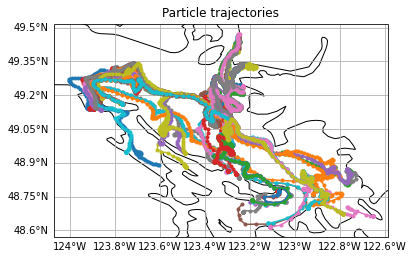

<module 'matplotlib.pyplot' from '/home/rlovindeer/conda_envs/parcels-dev/lib/python3.8/site-packages/matplotlib/pyplot.py'>

In [14]:
plotTrajectoriesFile('SandHeads2018-06-23_OP_D100.nc')

In [15]:
pfile = xr.open_dataset(str(output_file_name), decode_cf=True)

beached = np.ma.filled(pfile.variables['beached'], np.nan)
time = np.ma.filled(pfile.variables['time'], np.nan)
beach_time = beached.sum(axis=0)
particles_beached = np.diff(beach_time)
t1 = (time[1,:] - time[1,0])/(3600000000000)
t = t1[0:len(particles_beached)]

In [16]:
beached.shape

(100, 169)

(array([53., 25.,  1.,  3.,  2.,  2., 11., 18., 14., 17.]),
 array([ 0. ,  8.6, 17.2, 25.8, 34.4, 43. , 51.6, 60.2, 68.8, 77.4, 86. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

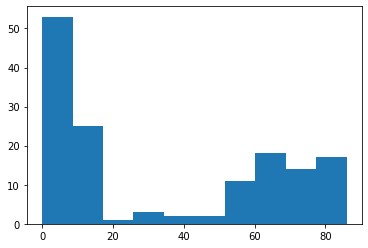

In [17]:
plt.hist(beach_time)

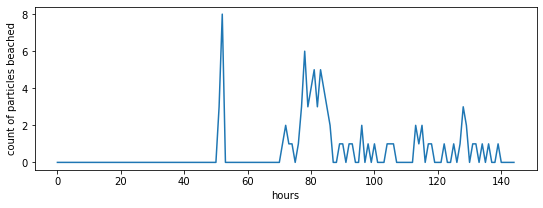

In [18]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (9,3))

ax.plot(t, particles_beached)
ax.set_xlabel('hours')
ax.set_ylabel('count of particles beached');
#np.histogram(beach_time)

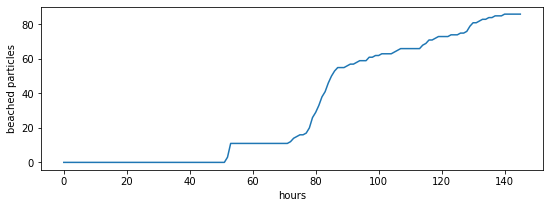

In [19]:
fig, ax = plt.subplots(figsize = (9,3))

t2 = (time[1,:] - time[1,0])/(3600000000000*24)
ax.plot(t1, beach_time)
ax.set_xlabel('hours')
ax.set_ylabel('beached particles');